In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error

In [2]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Prepare features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])  # exclude non-protein features
y = df['age']

In [14]:
#from sklearn.metrics import make_scorer
#rmse_scorer = make_scorer(root_mean_squared_error)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Ridge Regression with 10-fold cross-validation
ridge_cv = RidgeCV(alphas=(0.1, 1, 10, 100, 250, 500, 1000), cv=10, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_train, y_train)

# Best alpha
print(f"Best alpha (lambda): {ridge_cv.alpha_:.5f}")
best_alpha = ridge_cv.alpha_

# Store mean RMSE and std across folds
rmse_mean = []
rmse_std = []

# Alpha values to test
alphas = np.array([0.1, 1, 10, 100, 250, 500, 1000])

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    # 10-fold CV with negative RMSE (so we negate it back to positive)
    scores = cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
    rmse_scores = -scores  # Convert to positive RMSE
    rmse_mean.append(rmse_scores.mean())
    rmse_std.append(rmse_scores.std())

rmse_mean = np.array(rmse_mean)
rmse_std = np.array(rmse_std)


Best alpha (lambda): 250.00000


In [15]:
min_idx = np.argmin(rmse_mean)
one_se_threshold = rmse_mean[min_idx] + rmse_std[min_idx]
one_se_alpha = alphas[rmse_mean <= one_se_threshold][-1]

print(f"Alpha with 1-SE Rule (using RMSE): {one_se_alpha:.5f}")

Alpha with 1-SE Rule (using RMSE): 1000.00000


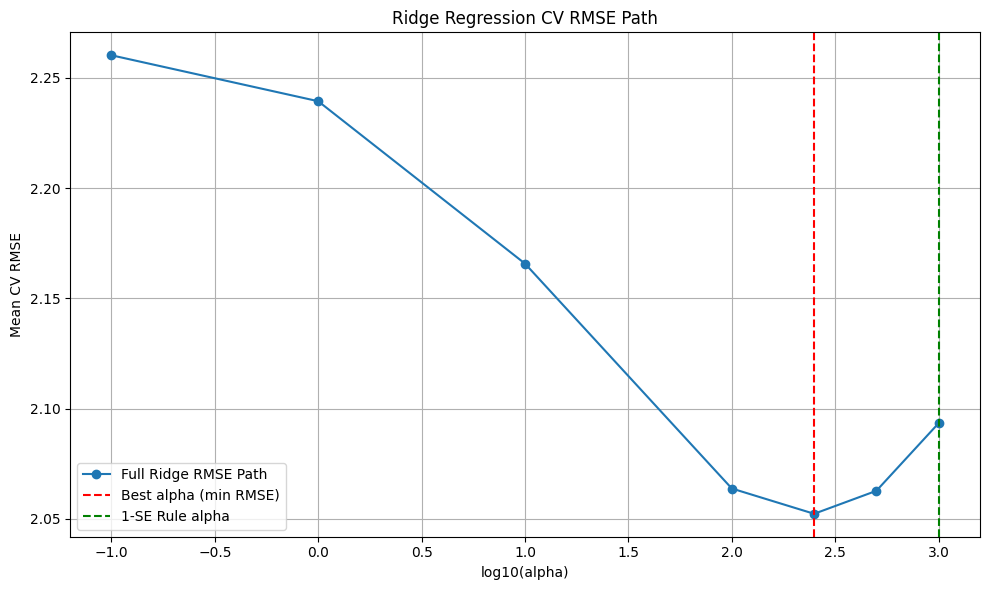

In [16]:
# Plot RMSE vs log10(alpha)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), rmse_mean, 'o-', label='Full Ridge RMSE Path')
plt.axvline(np.log10(best_alpha), color='red', linestyle='--', label='Best alpha (min RMSE)')
plt.axvline(np.log10(one_se_alpha), color='green', linestyle='--', label='1-SE Rule alpha')
plt.xlabel('log10(alpha)')
plt.ylabel('Mean CV RMSE')
plt.title('Ridge Regression CV RMSE Path')
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = "ridge_full_path.png"
plt.savefig(plot_path, dpi=300)
plt.show()

In [ ]:
# Predict on training and test sets
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# Calculate and print RMSE
train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

Train RMSE: 1.931
Test RMSE: 2.026


AttributeError: 'RidgeCV' object has no attribute 'mse_path_'

In [ ]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)


# Calculate R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")
print(f"R^2: {r2_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")
print(f"R^2: {r2_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)